<a href="https://colab.research.google.com/github/ariG23498/NeuralStyleTransfer/blob/master/%233Style_Representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Imports
The imports that have been used:
1. tensorflow
2. IPython.display
3. numpy
4. matplotlib
5. tqdm
6. copy
7. wandb
8. imageio
9. glob

In [2]:
import tensorflow as tf
from IPython.display import display, Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import glob

In [3]:
%%capture
# To generate GIFs
!pip install -q imageio
import imageio

In [4]:
%%capture
!pip install wandb
import wandb

In [5]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Data
* Visualize the data
* Pre-process the data

In [6]:
content_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
    )


style_path = tf.keras.utils.get_file(
    "starry_night.jpg",
    "https://i.imgur.com/9ooB60I.jpg")

print('Content Path: {}'.format(content_path))
print('Style Path: {}'.format(style_path))

942080/935806 [==============================] - 0s 0us/step
Content Path: /root/.keras/datasets/YellowLabradorLooking_new.jpg
Style Path: /root/.keras/datasets/starry_night.jpg


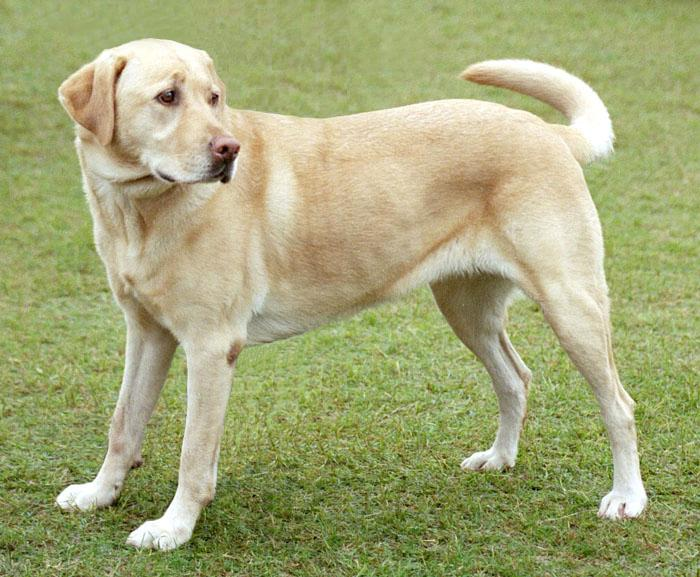

In [7]:
display(Image(content_path))

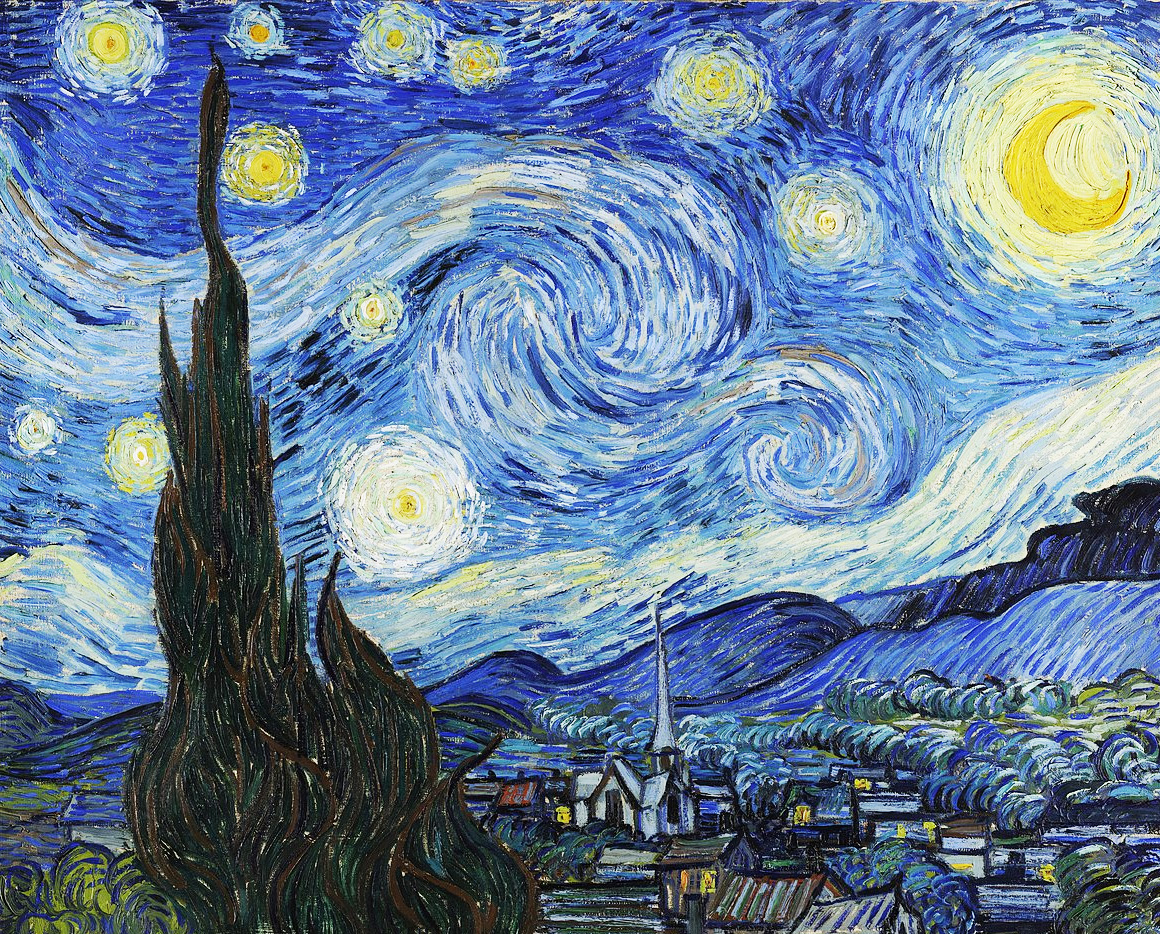

In [8]:
display(Image(style_path))

## Utils for the images
1. load_image - a function that loads image from the paths
2. imshow - a fuction to plot the image, when given a tensor
3. imsave - a fuction to save the image from a tensor

In [9]:
def load_img(path_to_img):
  '''
  This function helps load the image from the path
  inputs:
    path_to_img = The path of the image
  outputs:
    the image itself in form of tf.tensor
  '''
  # Open the file, reads content as string
  img = tf.io.read_file(path_to_img)
  # Decode image, (0 to 1)
  img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
  # Resizing image
  img = tf.image.resize(img, (224,224))
  # Expand dimension for the model (batch, h,w,c)
  img = tf.expand_dims(img,0)
  return img

def imshow(image, title=None):
  '''
  This function helps in visualizing the image
  inputs:
    image - Tensor
    title - The title of the plot
  '''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def imsave(image, name):
  '''
  This function helps in saving the image
  inputs:
    image - Tensor
    name - The name of the image
  '''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  fig = plt.figure(figsize=(5,5))
  plt.imshow(image)
  plt.axis('off')
  plt.savefig(name)
  plt.close()

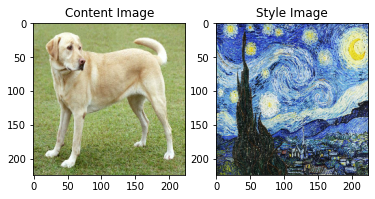

In [10]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1,2,2)
imshow(style_image, 'Style Image')

## GIF creation

In [11]:
def create_gif(path_to_images, name_gif):
  '''
  This function helps create a GIF
  inputs:
    path_to_images - path to the images
    name_gif - name of the GIF
  '''
  filenames = glob.glob(path_to_images)
  filenames = sorted(filenames)

  images = []
  for filename in tqdm(filenames):
    images.append(imageio.imread(filename))

  kargs = { 'duration': 0.25 }
  imageio.mimsave(name_gif, images, 'GIF', **kargs)

In [12]:
def show_gif(fname):
  '''
  This function helps interactively visualise a GIF
  inputs:
   fname - The GIF file name
  '''
  import base64
  from IPython import display
  with open(fname, 'rb') as fd:
      b64 = base64.b64encode(fd.read()).decode('ascii')
  return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

# Models
We will use the `VGG16` model.

And also make intermediate models for our convenience.

In [13]:
vgg = tf.keras.applications.VGG16(include_top=False, weights=None)
vgg.load_weights('/content/drive/My Drive/Colab Notebooks/Models/vgg16_norm_weights.h5')
vgg.trainable = False

In [14]:
LAYERS =  [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1']

vgg_models = list()
for layer_name in LAYERS:
  layer_output = vgg.get_layer(layer_name).output
  vgg_models.append(
      tf.keras.models.Model(inputs=vgg.input,outputs=layer_output)
  )

# Style Representations

In [15]:
def gram_matrix(input_tensor):
  '''
  inputs:
    inputs_tensor - Input Tensor
  outputs:
    Gram matrix of the tensor
  '''
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  return result

In [16]:
def compute_layer_style_cost(act_Style, act_Gen):
  '''
  inputs:
  act_Style - activation Style
  act_Gen - activation Generate
  outputs:
  The gram loss
  '''
  m, n_h, n_w, n_c = act_Gen.get_shape().as_list()

  GS = gram_matrix(act_Style)
  GG = gram_matrix(act_Gen)

  J_style_layer = tf.reduce_sum(tf.square(GS-GG))/((2 * n_c * n_w * n_h)**2)
  return J_style_layer

In [17]:
@tf.function()
def compute_style_cost(vgg_models, STYLE_LAYERS, style_image, generated_image):
  '''
  inputs:
    vgg_model - Intermediate VGG MODEL
    STYLE_LAYERS - The style layer
    gen_image - the generated image
  '''

  J_style = 0
  for idx, (layer_name, coeff) in enumerate(STYLE_LAYERS):
    pre_G = generated_image*255.0
    pre_G = tf.keras.applications.vgg19.preprocess_input(pre_G)
    act_G = vgg_models[idx](pre_G)

    pre_S = style_image*255.0
    pre_S = tf.keras.applications.vgg19.preprocess_input(pre_S)
    act_S = vgg_models[idx](pre_S)

    J_style_layer = compute_layer_style_cost(act_S, act_G)

    J_style += coeff * J_style_layer

  return J_style

In [18]:
STYLE_LAYERS = [
    ['block1_conv1', 0.2],
    ['block2_conv1', 0.2],
    ['block3_conv1', 0.2],
    ['block4_conv1', 0.2],
    ['block5_conv1', 0.2]]

In [19]:
# Test for output
white_noise = np.random.normal(size = (1,224,224,3), loc = 0.5, scale = 0.1)

compute_style_cost(vgg_models, STYLE_LAYERS, style_image, white_noise)

<tf.Tensor: shape=(), dtype=float32, numpy=2.3717475>

In [20]:
def train_step(vgg_models, STYLE_LAYERS, style_image, white_noise, loss_hist):
  with tf.GradientTape() as tape:
    style_loss = compute_style_cost(vgg_models, STYLE_LAYERS, style_image, white_noise)

  l = style_loss.numpy()
  wandb.log({"Loss": l})
  loss_hist.append(l)

  grad = tape.gradient(style_loss,white_noise)
  opt.apply_gradients([(grad, white_noise)])
  white_noise.assign(tf.clip_by_value(white_noise, clip_value_min=0.0, clip_value_max=1.0))

## Iterations

In [21]:
STYLE_LAYERS = [
    ['block1_conv1', 0],
    ['block2_conv1', 0],
    ['block3_conv1', 0],
    ['block4_conv1', 0],
    ['block5_conv1', 0]]

In [22]:
! mkdir layer0 layer1 layer2 layer3 layer4

In [23]:
# Test for loss and images
gen_images = list()
losses = list()
for idx in range(5):
  wandb.init(entity="authors", project="nerual_style_transfer", name="style_layer{}".format(idx))
  STYLE_LAYERS_temp = copy.deepcopy(STYLE_LAYERS)
  STYLE_LAYERS_temp[idx][1] = 1.0
  s = tf.constant(style_image)
  w = tf.Variable(np.random.normal(size = (1,224,224,3), loc = 0.5, scale = 0.1))
  opt = tf.keras.optimizers.Adam()
  loss_hist = list()
  for i in tqdm(range(500)):
    if i%50 == 0:
      imsave(w,'layer{}/style{}.png'.format(idx,i))
    train_step(vgg_models, STYLE_LAYERS_temp, s, w, loss_hist)
  create_gif('layer{}/style*.png'.format(idx), 'layer{}.gif'.format(idx))
  wandb.log({"video": wandb.Video('layer{}.gif'.format(idx), fps=4, format="gif")})
  gen_images.append(w)
  losses.append(loss_hist)

100%|██████████| 10/10 [00:00<00:00, 158.89it/s]


100%|██████████| 10/10 [00:00<00:00, 166.07it/s]


100%|██████████| 10/10 [00:00<00:00, 205.93it/s]


100%|██████████| 10/10 [00:00<00:00, 191.65it/s]


100%|██████████| 10/10 [00:00<00:00, 227.38it/s]


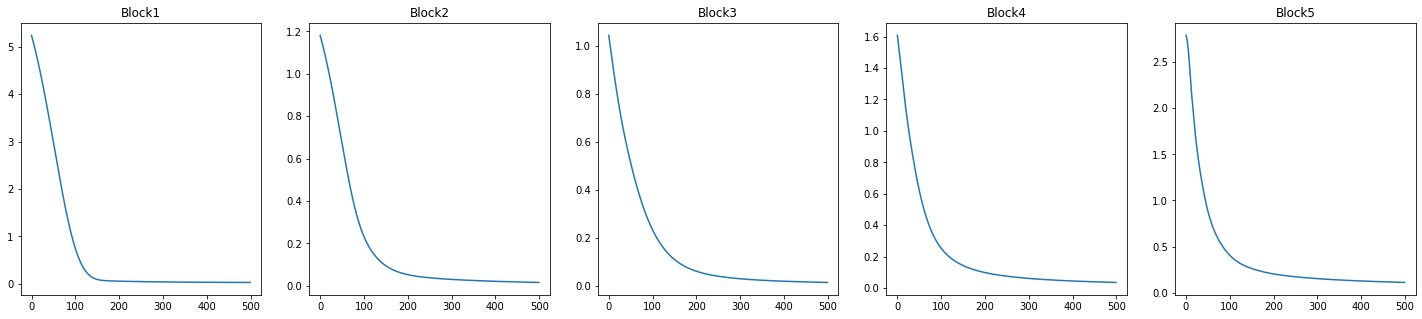

In [24]:
plt.figure(figsize=(25,5))
for idx, loss_hist in enumerate(losses):
  plt.subplot(1,5,idx+1)
  plt.plot(loss_hist)
  plt.title('Block{}'.format(idx+1))

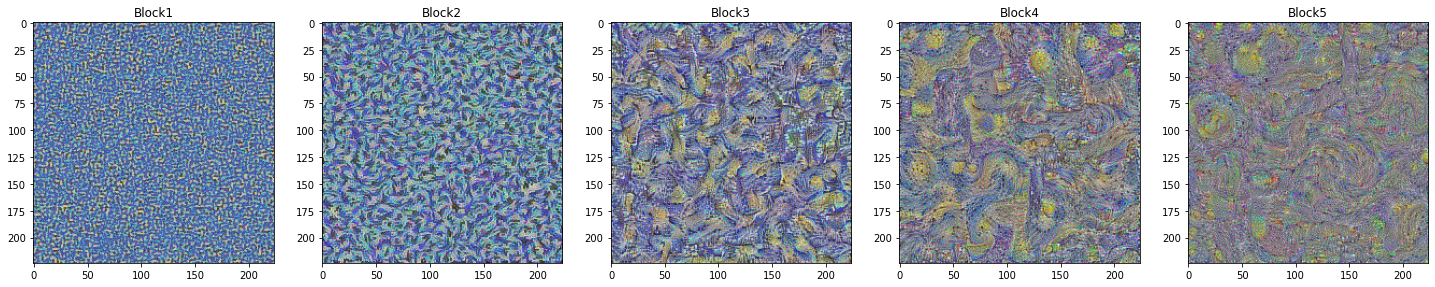

In [25]:
plt.figure(figsize=(25,5))
for idx, gen_image in enumerate(gen_images):
  plt.subplot(1,5,idx+1)
  imshow(gen_image, 'Block{}'.format(idx+1))


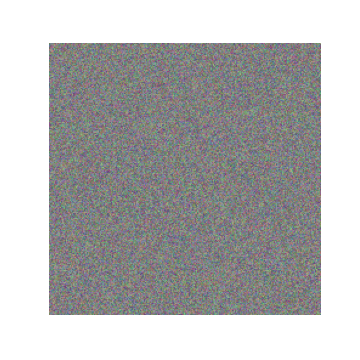

In [26]:
show_gif('layer4.gif')

## Aggregate

In [33]:
STYLE_LAYERS = [
    ['block1_conv1', 0.2],
    ['block2_conv1', 0.2],
    ['block3_conv1', 0.2],
    ['block4_conv1', 0.2],
    ['block5_conv1', 0.2]]

In [32]:
! mkdir aggregate

In [34]:
# Test for loss and images
s = tf.constant(style_image)
w = tf.Variable(np.random.normal(size = (1,224,224,3), loc = 0.5, scale = 0.1))
opt = tf.keras.optimizers.Adam()
loss_hist = list()
wandb.init(entity="authors", project="nerual_style_transfer", name="style_aggregate")
for i in tqdm(range(500)):
  if i%50 == 0:
      imsave(w,'aggregate/style{}.png'.format(i))
  train_step(vgg_models, STYLE_LAYERS, s, w, loss_hist)
create_gif('aggregate/style*.png', 'aggregate.gif')
wandb.log({"video": wandb.Video('aggregate.gif', fps=4, format="gif")})

100%|██████████| 10/10 [00:00<00:00, 202.03it/s]


Text(0.5, 1.0, 'All Blocks Aggregated')

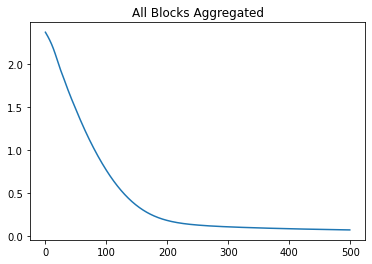

In [35]:
plt.plot(loss_hist)
plt.title('All Blocks Aggregated')

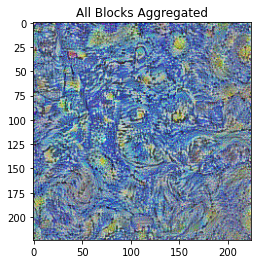

In [36]:
imshow(w, 'All Blocks Aggregated')


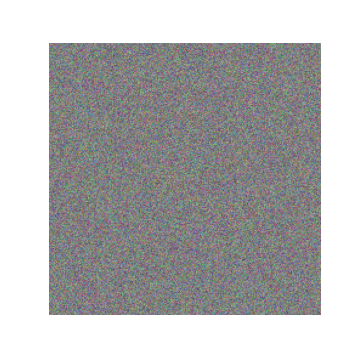

In [37]:
show_gif('aggregate.gif')